Setting up model
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-14
Creating decision variables
Creating constraints
Creating objective
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Working on a model with 288 decision variables
Working on a model with 900 constraints
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 7200
Set parameter LogFile to value "2D_BPP.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 900 rows, 288 columns and 4347 nonzeros
Model fingerprint: 0x31928210
Variable types: 18 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objec

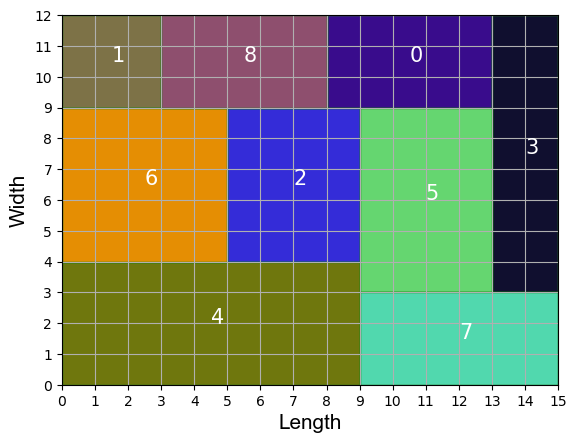

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 25 15:19:21 2022

@author: abombelli
"""
import numpy as np
import os
import pandas as pd
import time
from gurobipy import Model,GRB,LinExpr,quicksum
import random
import pickle
import matplotlib.pyplot as plt

cwd = os.getcwd()
plt.close('all')

# Set random seed
random.seed(42)

##################################
### Define initial set of bins ###
##################################

toy_model = True

if toy_model is False:

    # Dimensions of bins
    K   = {0:[150,100],
           1:[180,120]}
    
    # Costs of bins
    C_k = [100,130]
    
    ###########################
    ### Define set of items ###
    ###########################
    N = 15
    
    W_bin_max   = np.max(np.array(list(K.values()))[:,0])
    H_bin_max   = np.max(np.array(list(K.values()))[:,1])
    
    W_min = int(0.15*W_bin_max) 
    W_max = int(0.8*W_bin_max)
    H_min = int(0.15*H_bin_max) 
    H_max = int(0.8*H_bin_max)
    
    R = {i:[random.randint(W_min, W_max),random.randint(H_min, H_max)] for i in range(0,N)}
    
else:
    N   = 9
    K   = {0:[15,12]}
    C_k = [1]
    
    W_bin_max   = np.max(np.array(list(K.values()))[:,0])
    H_bin_max   = np.max(np.array(list(K.values()))[:,1])
    
    W_min = int(0.15*W_bin_max) 
    W_max = int(0.8*W_bin_max)
    H_min = int(0.15*H_bin_max) 
    H_max = int(0.8*H_bin_max)
    
    R = {0:[5,3],
         1:[3,3],
         2:[5,4],
         3:[2,9],
         4:[4,9],
         5:[6,4],
         6:[5,5],
         7:[6,3],
         8:[5,3]}
    
    

############################################################
### Define "inflated" set of bins given the set of items ###
############################################################

K_final = {}
for idx_b,k in enumerate(list(K.keys())):
    for idx_i  in R.keys():
        K_final[idx_b*N+idx_i] = [idx_b,K[idx_b],C_k[idx_b]]
        
#################################
### 2D BPP OPTIMIZATION MODEL ###
#################################

print('Setting up model')

start_time = time.time()  

# Setup model
model = Model()

print('Creating decision variables')
l = {}
b = {}
f = {}
z = {}
x = {}
y = {}
r = {}

for i in R.keys():
    for j in R.keys():
        if j != i:
            l[i,j]=model.addVar(lb=0, ub=1, vtype=GRB.BINARY,name="l[%s,%s]"%(i,j))
            b[i,j]=model.addVar(lb=0, ub=1, vtype=GRB.BINARY,name="b[%s,%s]"%(i,j))

for i in R.keys():
    for k in K_final.keys():
        f[i,k]=model.addVar(lb=0, ub=1, vtype=GRB.BINARY,name="f[%s,%s]"%(i,k))
        

for k in K_final.keys():
    z[k]=model.addVar(lb=0, ub=1, vtype=GRB.BINARY,name="z[%s]"%(k))
    
for i in R.keys():
    x[i]=model.addVar(lb=0, ub=W_bin_max, vtype=GRB.CONTINUOUS,name="x[%s]"%(i))
    y[i]=model.addVar(lb=0, ub=H_bin_max, vtype=GRB.CONTINUOUS,name="y[%s]"%(i))
    
for i in R.keys():
    for aa in range(0,2):
        for bb in range (0,2):
            r[i,aa,bb]=model.addVar(lb=0, ub=1, vtype=GRB.BINARY,name="r[%s,%s,%s]"%(i,aa,bb))

model.update()
            
print('Creating constraints')
for i in R.keys():
    for j in R.keys():
        if i < j:
            for k in K_final.keys():
                lhs = LinExpr()
                lhs += l[i,j]+l[j,i]+b[i,j]+b[j,i]+(1-f[i,k])+(1-f[j,k])
                model.addConstr(lhs=lhs, sense=GRB.GREATER_EQUAL, rhs=1,
                name='no_overlap_[%s,%s,%s]'%(i,j,k)) 
                

for i in R.keys():
    for j in R.keys():
        if i != j:
            
            lhs = LinExpr()
            lhs += x[i]+R[i][0]*r[i,0,0]+R[i][1]*r[i,0,1]-x[j]+W_bin_max*l[i,j]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=W_bin_max,
            name='horizontal_recipr_1[%s,%s]'%(i,j))
            lhs = LinExpr()
            lhs += x[j]-x[i]-R[i][0]*r[i,0,0]-R[i][1]*r[i,0,1]-W_bin_max*l[i,j]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=0,
            name='horizontal_recipr_2[%s,%s]'%(i,j))
            lhs = LinExpr()
            lhs += y[i]+R[i][0]*r[i,1,0]+R[i][1]*r[i,1,1]-y[j]+H_bin_max*b[i,j]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=H_bin_max,
            name='vertical_recipr_1[%s,%s]'%(i,j))
            lhs = LinExpr()
            lhs += y[j]-y[i]-R[i][0]*r[i,1,0]-R[i][1]*r[i,1,1]-H_bin_max*b[i,j]
            model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=0,
            name='vertical_recipr_2[%s,%s]'%(i,j))

for i in R.keys():
    for k in K_final.keys():
        lhs = LinExpr()
        lhs += x[i]+R[i][0]*r[i,0,0]+R[i][1]*r[i,0,1]+W_bin_max*f[i,k]  
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=K_final[k][1][0]+W_bin_max,
            name='horizontal_item_bin[%s,%s]'%(i,k)) 
        lhs = LinExpr()
        lhs += y[i]+R[i][0]*r[i,1,0]+R[i][1]*r[i,1,1]+H_bin_max*f[i,k]  
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=K_final[k][1][1]+H_bin_max,
            name='vertical_item_bin[%s,%s]'%(i,k))
        
for i in R.keys():
    for aa in range(0,2):
        lhs = LinExpr()
        for bb in range(0,2):
            lhs += r[i,aa,bb]
        model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=1,
            name='rotation_item_binSide[%s,%s]'%(i,aa))

for i in R.keys():
    for bb in range(0,2):
        lhs = LinExpr()
        for aa in range(0,2):
            lhs += r[i,aa,bb]
        model.addConstr(lhs=lhs, sense=GRB.EQUAL, rhs=1,
            name='rotation_item_itemSide[%s,%s]'%(i,bb))
        
for i in R.keys():
    lhs = LinExpr()
    for k in K_final.keys():
        lhs += f[i,k]
    model.addConstr(lhs=lhs, sense=GRB.GREATER_EQUAL, rhs=1,
            name='assignment_item[%s]'%(i))
    
for i in R.keys():
    for k in K_final.keys():
        lhs = LinExpr()
        lhs += f[i,k]-z[k]
        model.addConstr(lhs=lhs, sense=GRB.LESS_EQUAL, rhs=0,
            name='usage_bin_item[%s,%s]'%(k,i))

print('Creating objective')

obj = LinExpr()

for k in K_final.keys():
    obj += K_final[k][2]*z[k]

model.setObjective(obj,GRB.MINIMIZE)

model.update()


model.write('2D_BPP.lp') 

print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
print('Working on a model with %i decision variables'%(len(model.getVars())))
print('Working on a model with %i constraints'%(len(model.getConstrs())))
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%') 

# Solve
model.setParam('MIPGap',0.001)
model.setParam('TimeLimit',2*3600)
model.params.LogFile='2D_BPP.log'

model.optimize()
endTime   = time.time()  

solution = []

# Retrieve variable names and values
for v in model.getVars():
    solution.append([v.varName,v.x])
    
active_variables       = []
active_variables_names = []
for i in range(0,len(solution)):
    # Adding binary variables that are unitary
    if solution[i][0][0] != 'x' and solution[i][0][0] != 'y': 
        if solution[i][1] >= 0.99:
            active_variables.append([solution[i][0],solution[i][1]]) 
            active_variables_names.append(solution[i][0])
    # Adding (x,y) coordinates of all items
    else:
        active_variables.append([solution[i][0],solution[i][1]]) 
        active_variables_names.append(solution[i][0])
    
# Determine bins that are used
bins_used = []
for i in range(0,len(active_variables)):
    if active_variables[i][0][0] == 'z':
        idx_openBr   = [pos for pos, char in enumerate(active_variables[i][0]) if char == '[' ][0]
        idx_closedBr = [pos for pos, char in enumerate(active_variables[i][0]) if char == ']' ][0]
        bins_used.append(int(active_variables[i][0][idx_openBr+1:idx_closedBr]))

# Determine for each item the bin is assigned to, the position of the 
# lower left corner, and the orientation

Items_in_Bin    = {i:[] for i in K_final.keys()}
for i in R.keys():
    for this_bin in bins_used:
        if 'f[%s,%s]'%(i,this_bin) in active_variables_names:
            Items_in_Bin[this_bin].append(i)
            
R_info_solution = {}
for i in R.keys():
    x_pos = active_variables[np.where(np.array(active_variables_names)=='x[%s]'%(i))[0][0]][1]
    y_pos = active_variables[np.where(np.array(active_variables_names)=='y[%s]'%(i))[0][0]][1]
    if 'r[%s,0,0]'%(i) in active_variables_names:
        horiz_extension = R[i][0]
        vert_extension  = R[i][1]
    else:
        horiz_extension = R[i][1]
        vert_extension  = R[i][0]
        
    R_info_solution[i] = [x_pos,y_pos,horiz_extension,vert_extension]

#%%
plt.close('all')
axis_font  = {'fontname':'Arial', 'size':'15'}
    
#########################
### Plotting solution ###
#########################
from matplotlib.patches import Rectangle

for this_bin in bins_used:
    fig, ax = plt.subplots()
    for item in Items_in_Bin[this_bin]:
        ax.add_patch(Rectangle((R_info_solution[item][0],
                                R_info_solution[item][1]),
                               R_info_solution[item][2],R_info_solution[item][3],
             edgecolor = 'green',
             facecolor =  [random.randint(0,255)/255, 
                           random.randint(0,255)/255, 
                           random.randint(0,255)/255 ],
             fill=True,
             lw=1))
        plt.text(R_info_solution[item][0]+0.5*R_info_solution[item][2],
                 R_info_solution[item][1]+0.5*R_info_solution[item][3],
                 str(item),fontsize=15,color='w')
    ax.set_xlim(0,K_final[this_bin][1][0])
    ax.set_ylim(0,K_final[this_bin][1][1])
    ax.set_xticks(range(0,K_final[this_bin][1][0]+1))
    ax.set_yticks(range(0,K_final[this_bin][1][1]+1))
    ax.set_xlabel('Length',**axis_font)
    ax.set_ylabel('Width',**axis_font)
    ax.grid(True)
    plt.show()
    fig.savefig('bin_%i.png'%(this_bin), format='png', dpi=400, bbox_inches='tight',
             transparent=True,pad_inches=0.02)